In [1]:
#@markdown #1. Install the dependencies

from tabulate import tabulate
from astropy.visualization import simple_norm

from ipywidgets import interact

import numpy as np
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import os, random
import shutil 
import zipfile
from tifffile import imread, imsave


#from skimage.io import imread
#import skimage.io



def ssim(img1, img2):
  return structural_similarity(img1,img2,data_range=1.,full=True, gaussian_weights=True, use_sample_covariance=False, sigma=1.5)


def normalize(x, pmin=3, pmax=99.8, axis=None, clip=False, eps=1e-20, dtype=np.float32):
    """This function is adapted from Martin Weigert"""
    """Percentile-based image normalization."""

    mi = np.percentile(x,pmin,axis=axis,keepdims=True)
    ma = np.percentile(x,pmax,axis=axis,keepdims=True)
    return normalize_mi_ma(x, mi, ma, clip=clip, eps=eps, dtype=dtype)


def normalize_mi_ma(x, mi, ma, clip=False, eps=1e-20, dtype=np.float32):#dtype=np.float32
    """This function is adapted from Martin Weigert"""
    if dtype is not None:
        x   = x.astype(dtype,copy=False)
        mi  = dtype(mi) if np.isscalar(mi) else mi.astype(dtype,copy=False)
        ma  = dtype(ma) if np.isscalar(ma) else ma.astype(dtype,copy=False)
        eps = dtype(eps)

    try:
        import numexpr
        x = numexpr.evaluate("(x - mi) / ( ma - mi + eps )")
    except ImportError:
        x =                   (x - mi) / ( ma - mi + eps )

    if clip:
        x = np.clip(x,0,1)

    return x

def norm_minmse(gt, x, normalize_gt=True):
    """This function is adapted from Martin Weigert"""

    """
    normalizes and affinely scales an image pair such that the MSE is minimized  
     
    Parameters
    ----------
    gt: ndarray
        the ground truth image      
    x: ndarray
        the image that will be affinely scaled 
    normalize_gt: bool
        set to True of gt image should be normalized (default)
    Returns
    -------
    gt_scaled, x_scaled 
    """
    if normalize_gt:
        gt = normalize(gt, 0.1, 99.9, clip=False).astype(np.float32, copy = False)
    x = x.astype(np.float32, copy=False) - np.mean(x)    
    gt = gt.astype(np.float32, copy=False) - np.mean(gt)    
    scale = np.cov(x.flatten(), gt.flatten())[0, 1] / np.var(x.flatten())
    return gt, scale * x



In [2]:
#@markdown #2. Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(200, 24, 404, 389)
The First frame will be used as a reference
---------------------------
Stack shape: (200, 404, 389)


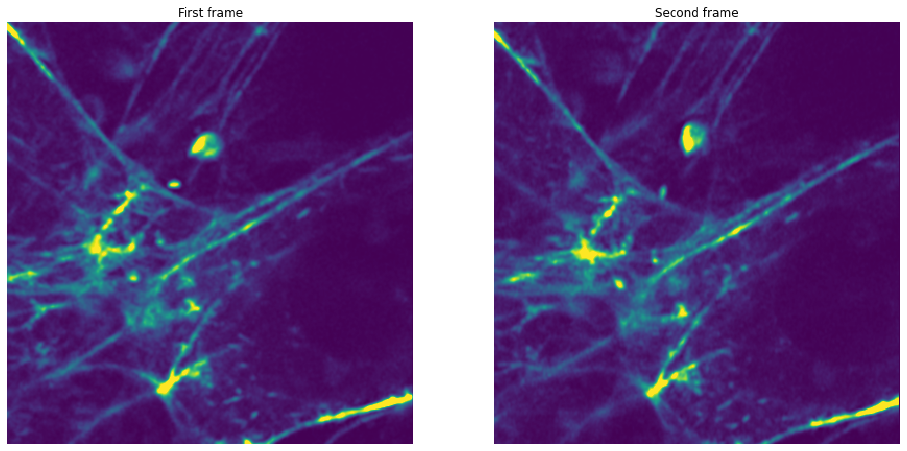

In [5]:
#@markdown #3. Choose the folders that contain the data to analyse and run to load the data. One example will be displayed

Source_folder = "/content/gdrive/Shareddrives/Fast4DReg/LongTimelapse-first" #@param{type:"string"}
Result_folder = "/content/gdrive/Shareddrives/Fast4DReg/LongTimelapse-first-results" #@param{type:"string"}

Analysis_type = "Z-slice" #@param ["Max_projection", "Z-slice"]

Reference_Frame = "First" #@param ["First", "Previous"]


#@markdown ##If not Max_projection, choose the Z plane to analyse
Z_plane =  8#@param {type:"number"}

# -------------------------------- Load the stack --------------------------------

random_choice=random.choice(os.listdir(Source_folder))

stack = imread(Source_folder+"/"+random_choice)

print(stack.shape)

if Reference_Frame == "Previous":           
  print('The Previous frame will be used as a reference')

if Reference_Frame == "First": 
  print('The First frame will be used as a reference')


# perform the max projection

if Analysis_type == "Max_projection":
  #make max projection
  maxproj = np.max(stack[:,:,:,:],axis = 1)
  print('---------------------------')
  print('max projection shape', maxproj.shape)


if Analysis_type == "Z-slice":
  maxproj = stack[:,Z_plane,:,:]

  print('---------------------------')
  print('Stack shape:', maxproj.shape)



#Display one image

f=plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(maxproj[0], norm=simple_norm(maxproj[0], percent = 99), interpolation='nearest')

plt.axis('off')
plt.title('First frame');
plt.subplot(1,2,2)
plt.imshow(maxproj[1], norm=simple_norm(maxproj[1], percent = 99), interpolation='nearest')
plt.axis('off')
plt.title('Second frame');






In [6]:
#@markdown #4. Process the data

import csv
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio as psnr

if Analysis_type == "Max_projection":
  Z_plane = ""



for i in os.listdir(Source_folder):
  if not os.path.isdir(os.path.join(Source_folder,i)):
    print('Running QC on: '+i)
    stack = imread(Source_folder+"/"+i)

    if Analysis_type == "Max_projection":
  
      maxproj = np.max(stack[:,:,:,:],axis = 1)

    if Analysis_type == "Z-slice":
      maxproj = stack[:,Z_plane,:,:]

# Open and create the csv file that will contain all the QC metrics
    with open(Result_folder+"/"+"QC_metrics_"+i+"_"+Analysis_type+str(Z_plane)+"_"+Reference_Frame+".csv", "w", newline='') as file:
        writer = csv.writer(file)

    # Write the header in the csv file
        writer.writerow(["image #","Z plane","Z plane + 1", "mSSIM", "NRMSE", "PSNR", "Pearson coefficient"])  

        # Initialize the lists
        Z_plane_list = []
        ssim_score_list = []
        Pearson_correlation_coefficient_list = []
          
    # Let's loop through the provided dataset in the QC folders

        for z in range(maxproj.shape[0]-1):

          Z_plane_list.append(z)            
      # -------------------------------- Load the data --------------------------------
          if Reference_Frame == "Previous":           
            test_GT = maxproj[z+1]                     
            test_source = maxproj[z]

          if Reference_Frame == "First":           
            test_GT = maxproj[z+1]                     
            test_source = maxproj[0]

      # Normalize the images wrt each other by minimizing the MSE between GT and Source image
          test_GT_norm,test_source_norm = norm_minmse(test_GT, test_source, normalize_gt=True)

      # -------------------------------- Calculate the metric maps and save them --------------------------------

      # Calculate the SSIM maps
          index_SSIM_GTvsSource, img_SSIM_GTvsSource = ssim(test_GT_norm, test_source_norm)

          ssim_score_list.append(index_SSIM_GTvsSource)

      #Save ssim_maps

            #img_SSIM_GTvsSource_8bit = (img_SSIM_GTvsSource* 255).astype("uint8")
            #io.imsave(QC_model_path+'/'+QC_model_name+"/Quality Control/"+str(checkpoints)+"/SSIM_GTvsSource_"+shortname_no_PNG+'.tif',img_SSIM_GTvsSource_8bit)
      
      # Calculate the Root Squared Error (RSE) maps
          img_RSE_GTvsSource = np.sqrt(np.square(test_GT_norm - test_source_norm))

      # Save SE maps
            #img_RSE_GTvsSource_8bit = (img_RSE_GTvsSource* 255).astype("uint8")
            #io.imsave(QC_model_path+'/'+QC_model_name+"/Quality Control/"+str(checkpoints)+"/RSE_GTvsSource_"+shortname_no_PNG+'.tif',img_RSE_GTvsSource_8bit)


      # -------------------------------- Calculate the RSE metrics and save them --------------------------------

      # Normalised Root Mean Squared Error (here it's valid to take the mean of the image)
          NRMSE_GTvsSource = np.sqrt(np.mean(img_RSE_GTvsSource))
        
      # We can also measure the peak signal to noise ratio between the images
          PSNR_GTvsSource = psnr(test_GT_norm,test_source_norm,data_range=1.0)


          cm1 = np.corrcoef(test_GT_norm.flat, test_source_norm.flat) #outputs a flat number
          r1 = cm1[0, 1]
          Pearson_correlation_coefficient_list.append(r1)

          writer.writerow([i,str(z),str(z+1),str(index_SSIM_GTvsSource),str(NRMSE_GTvsSource),str(PSNR_GTvsSource),str(r1)])

# All data is now processed saved


from tabulate import tabulate
import pandas as pd

print('--------------------------------------------------------------')
@interact
def show_QC_results(file = os.listdir(Result_folder)):
  df = pd.read_csv (Result_folder+"/"+file)
  df.set_index("image #", inplace=True)
  print(tabulate(df, headers='keys', tablefmt='psql'))

  Z_plane_list = df['Z plane + 1'].values.tolist()
  ssim_score_list = df['mSSIM'].values.tolist()
  Pearson_correlation_coefficient_list = df['Pearson coefficient'].values.tolist()

# -------------------------------- Display --------------------------------

  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list, ssim_score_list, label="SSIM")
  plt.title('Z plane vs. SSIM')
  plt.ylabel('SSIM')
  plt.xlabel('Z plane')
  plt.legend()
#plt.savefig(full_QC_model_path+'/Quality Control/SSIMvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.show()


  plt.figure(figsize=(20,5))
  plt.plot(Z_plane_list, Pearson_correlation_coefficient_list, label="Pearson coefficient")
  plt.title('Z plane vs. Pearson coefficient')
  plt.ylabel('Pearson coefficient')
  plt.xlabel('Z plane')
  plt.legend()
#plt.savefig(full_QC_model_path+'/Quality Control/lpipsvsCheckpoint_data.png',bbox_inches='tight',pad_inches=0)
  plt.show()


<tifffile.TiffPage 0 @8> imagej_metadata failed with ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


Running QC on: 1-bc_Image11_originaa-crop.tif
Running QC on: 2-bc_Image11_Fast4D_crop.tif
Running QC on: 3-bc_Image11_3DDcorrected-crop.tif
--------------------------------------------------------------


interactive(children=(Dropdown(description='file', options=('QC_metrics_1-bc_Image11_originaa-crop.tif_Z-slice…